In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cleaned_power_data.csv')
df['일시'] = pd.to_datetime(df['일시'])
df['year'] = df['일시'].dt.year
df['month'] = df['일시'].dt.month
df['day'] = df['일시'].dt.day

In [3]:
feature_cols = [
    'year', 'month', 'day',
    '일강수량(mm)_norm',
    '평균 풍속(m/s)_norm',
    '최대 풍속(m/s)_norm',
    '평균기온(°C)_norm',
    '최저기온(°C)_norm',
    '최고기온(°C)_norm'
]
target_col = '최대전력(MW)'

In [4]:
for col in feature_cols:
    if df[col].isnull().any():
        for idx, row in df[df[col].isnull()].iterrows():
            year, month, day = row['year'], row['month'], row['day']
            prev_years = df[(df['month'] == month) & (df['day'] == day) & (df['year'].isin([year-1, year-2]))]
            if not prev_years.empty:
                df.at[idx, col] = prev_years[col].mean()
            else:
                df.at[idx, col] = df[col].mean()

In [5]:
df = df.dropna(subset=[target_col])

In [6]:
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, 'model_rf.pkl')
print("RandomForest 모델 저장 완료: model_rf.pkl")

RandomForest 모델 저장 완료: model_rf.pkl


In [7]:
df_prophet = df[['일시', target_col]].rename(columns={'일시': 'ds', target_col: 'y'})
prophet = Prophet()
prophet.fit(df_prophet)
future = prophet.make_future_dataframe(periods=7)
forecast = prophet.predict(future)
forecast.to_csv('prophet_forecast.csv', index=False)
print("Prophet 예측 결과 저장 완료: prophet_forecast.csv")

23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet 예측 결과 저장 완료: prophet_forecast.csv


In [8]:
rf_pred = rf.predict(X_test)
rf_supply = rf_pred * 1.15
print(f"RandomForest 예측값(샘플): {rf_pred[:5]}")
print(f"공급 권장 전력(샘플, 115%): {rf_supply[:5]}")

RandomForest 예측값(샘플): [55421.95 47995.92 72453.57 77847.52 41217.71]
공급 권장 전력(샘플, 115%): [63735.2425 55195.308  83321.6055 89524.648  47400.3665]


In [9]:
import matplotlib.pyplot as plt
import matplotlib

# 윈도우의 경우(예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 만약 Mac이면 'AppleGothic', 리눅스면 'NanumGothic' 등으로 변경

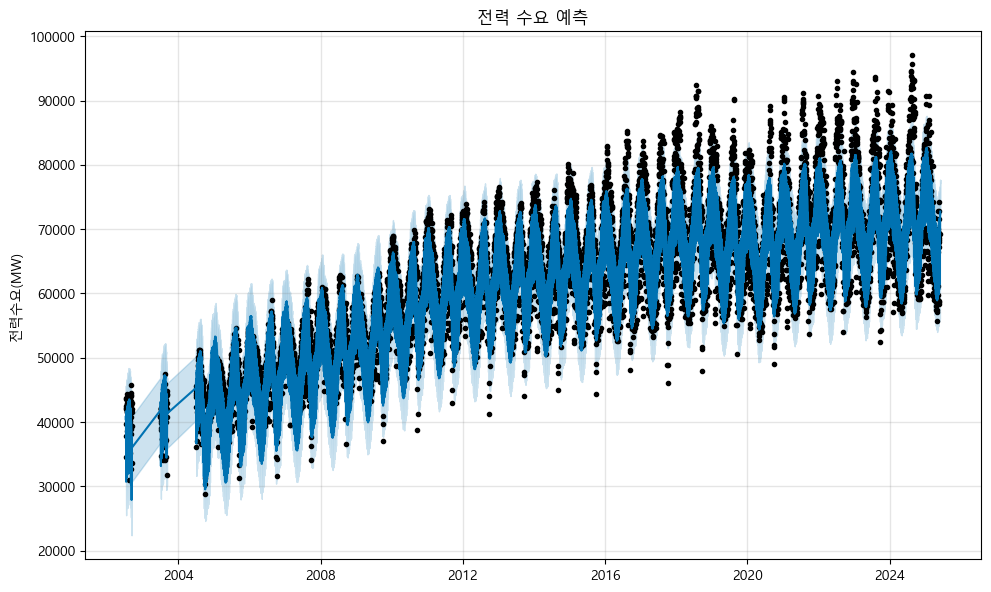

In [10]:
fig1 = prophet.plot(forecast)
plt.title('전력 수요 예측')
plt.xlabel('')
plt.ylabel('전력수요(MW)')
plt.show()

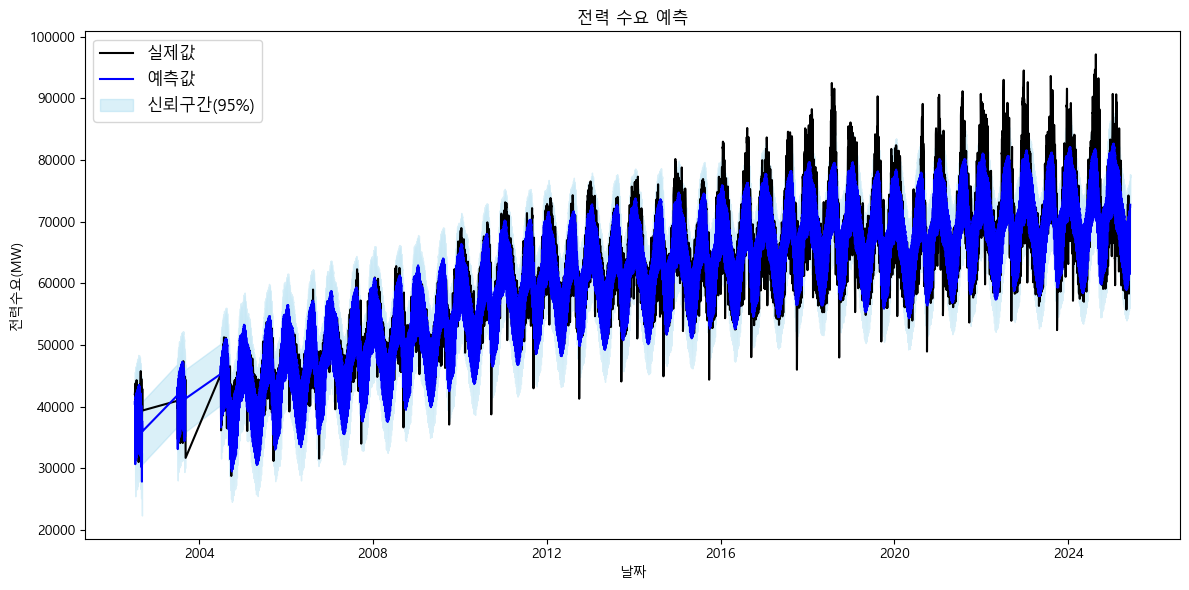

In [11]:

import matplotlib.pyplot as plt

# Prophet 예측 결과가 아래와 같이 준비되어 있다고 가정합니다.
# df_prophet: 실제값 데이터프레임 (컬럼: ds, y)
# forecast: Prophet 예측 결과 데이터프레임 (컬럼: ds, yhat, yhat_lower, yhat_upper)

plt.figure(figsize=(12,6))
plt.title('전력 수요 예측')

# 실제값 (검정선)
plt.plot(df_prophet['ds'], df_prophet['y'], color='black', label='실제값')

# 예측값 (파란선)
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='예측값')

# 신뢰구간 (연한 파랑)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='skyblue', alpha=0.3, label='신뢰구간(95%)')

plt.xlabel('날짜')
plt.ylabel('전력수요(MW)')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
   rf = RandomForestRegressor(random_state=42)
   rf.fit(X_train, y_train)
   joblib.dump(rf, 'model_rf.pkl')

['model_rf.pkl']

In [13]:
   prophet = Prophet()
   prophet.fit(df_prophet)
   future = prophet.make_future_dataframe(periods=7)
   forecast = prophet.predict(future)
   forecast.to_csv('prophet_forecast.csv', index=False)

23:09:10 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
  print(rf.score(X_test, y_test))  # R^2 결정계수

0.7923092149209636


In [15]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 예측값
y_pred = rf.predict(X_test)

# R² (결정계수)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# MAE (평균절대오차)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# RMSE (평균제곱근오차)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

R²: 0.7923
MAE: 4289.23
RMSE: 5304.29


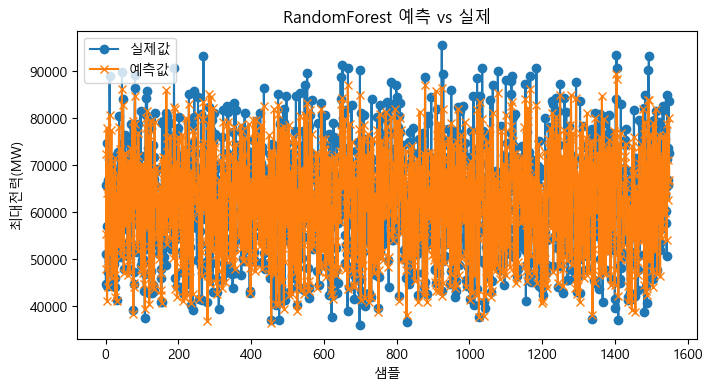

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='실제값', marker='o')
plt.plot(y_pred, label='예측값', marker='x')
plt.legend()
plt.title('RandomForest 예측 vs 실제')
plt.xlabel('샘플')
plt.ylabel('최대전력(MW)')
plt.show()

In [17]:
# Prophet 예측 결과와 실제값 병합
df_compare = forecast.merge(df_prophet, on='ds', how='inner')

# R², MAE, RMSE 계산
r2 = r2_score(df_compare['y'], df_compare['yhat'])
mae = mean_absolute_error(df_compare['y'], df_compare['yhat'])
rmse = np.sqrt(mean_squared_error(df_compare['y'], df_compare['yhat']))

print(f"Prophet R²: {r2:.4f}")
print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

Prophet R²: 0.8889
Prophet MAE: 2765.20
Prophet RMSE: 3895.52


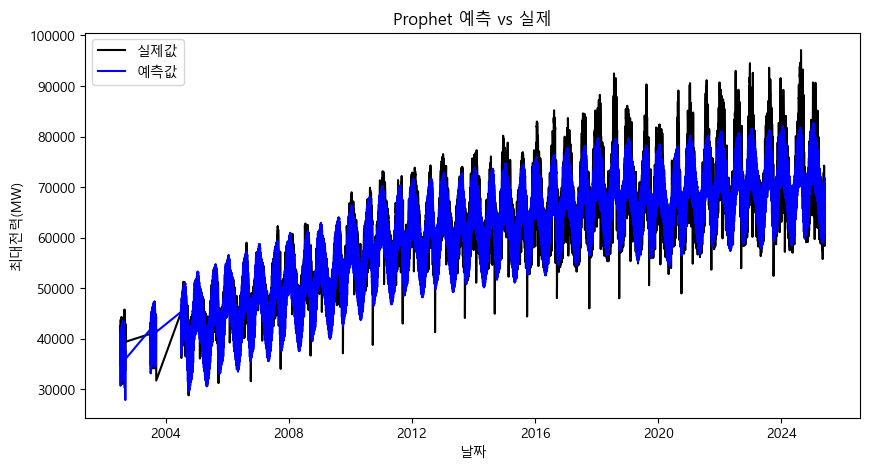

In [18]:
plt.figure(figsize=(10,5))
plt.plot(df_compare['ds'], df_compare['y'], label='실제값', color='black')
plt.plot(df_compare['ds'], df_compare['yhat'], label='예측값', color='blue')
plt.legend()
plt.title('Prophet 예측 vs 실제')
plt.xlabel('날짜')
plt.ylabel('최대전력(MW)')
plt.show()

In [19]:
  for name, score in zip(feature_cols, rf.feature_importances_):
      print(f"{name}: {score:.4f}")

year: 0.6391
month: 0.0116
day: 0.0266
일강수량(mm)_norm: 0.0169
평균 풍속(m/s)_norm: 0.0252
최대 풍속(m/s)_norm: 0.0262
평균기온(°C)_norm: 0.0963
최저기온(°C)_norm: 0.0859
최고기온(°C)_norm: 0.0722
